In [5]:
import dotenv
import bluequbit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
TOKEN = dotenv.dotenv_values(".env")["TOKEN"]
IBMQ = '832ce3eeb6b5034170505cd4ece2c8918d160504662ff1ec71da90dafb81ce2ca6dfa80f969fe92988a88d7b72da0bb7114e537aeb058e280a9bc8f4e231b06e'  # default URL provided

python-dotenv could not parse statement starting at line 2


In [4]:
qc = QuantumCircuit.from_qasm_file('quasms\P3__sharp_peak.qasm')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\danie\AppData\Local\Temp\ipykernel_20004\3902560951.py:1: SyntaxWarning: invalid escape sequence '\P'
  qc = QuantumCircuit.from_qasm_file('quasms\P3__sharp_peak.qasm')


In [6]:
# Save your IBM Quantum API token so that the service can access it
service = QiskitRuntimeService(channel="ibm_quantum", token=IBMQ)

In [7]:
backend = service.backend('ibm_sherbrooke')

In [11]:
qc.num_qubits

44

In [8]:
qc.count_ops()

OrderedDict([('u3', 399), ('cz', 178)])

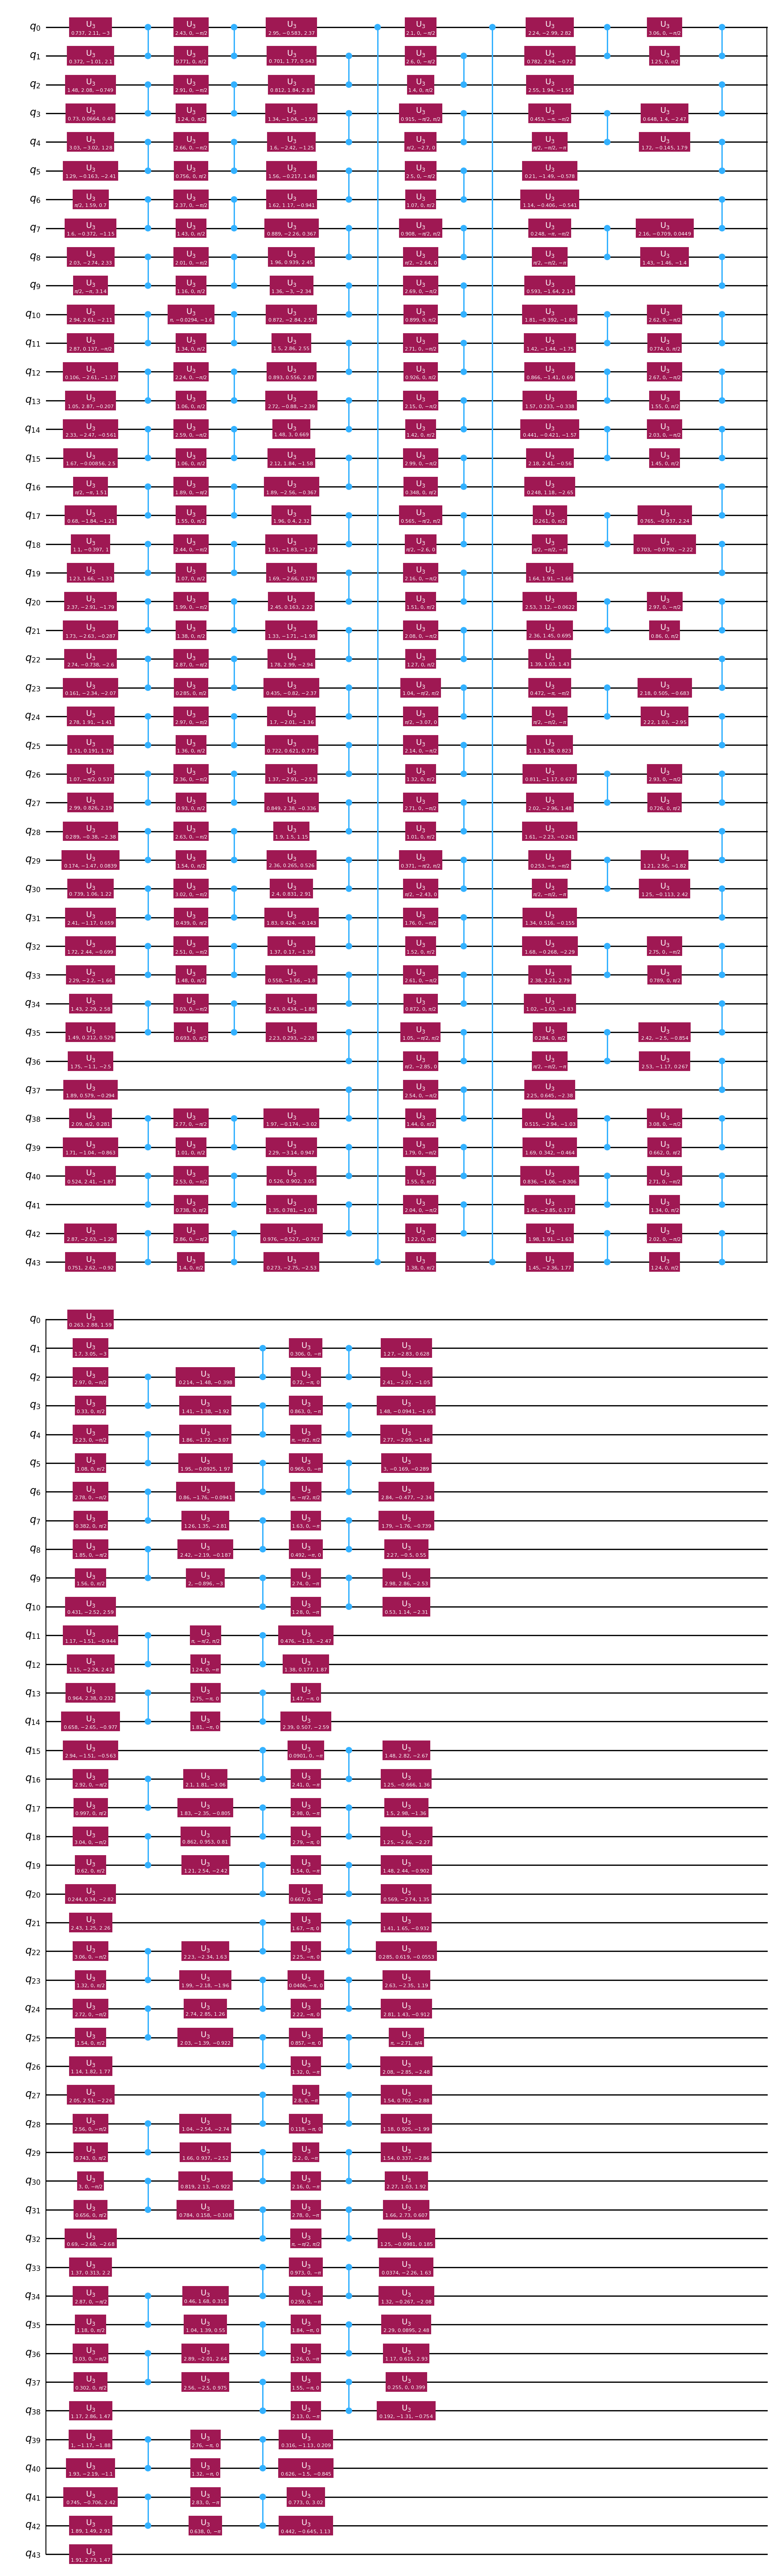

In [5]:

qc.draw('mpl', filename='P3.png')

In [12]:
## definiendo observables
from qiskit.quantum_info import SparsePauliOp
import numpy as np
num_qubits = 44
pauli_list = []
coeffs = []
# Ejemplo: definir M_z = Z_0 + Z_1 + ... + Z_47
for i in range(num_qubits):
    # Construimos un string de 48 caracteres que sea 'I' en todos lados,
    # y 'Z' solamente en la posición i.
    pauli_str = ['I'] * num_qubits
    pauli_str[i] = 'Z'
    pauli_list.append(''.join(pauli_str))
    coeffs.append(3.08)  # o el coeficiente que corresponda
# Ejemplo de interacciones entre qubits vecinos (si el sistema tiene esta topología)
for i in range(num_qubits - 1):
    pauli_str = ['I'] * num_qubits
    pauli_str[i] = 'Z'
    pauli_str[i + 1] = 'Z'
    pauli_list.append(''.join(pauli_str))
    coeffs.append(-3.08)
observable = SparsePauliOp(pauli_list, coeffs=np.array(coeffs))

In [9]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

### Particion del Circuito

In [13]:
# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=34)

In [14]:
cut_circuit, metadata = find_cuts(qc, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)

Found solution using 6 cuts with a sampling overhead of 531441.0.
Lowest cost solution found: False.


Gate Cut at circuit instruction index 428
Gate Cut at circuit instruction index 431
Gate Cut at circuit instruction index 461
Gate Cut at circuit instruction index 464
Gate Cut at circuit instruction index 547
Gate Cut at circuit instruction index 550


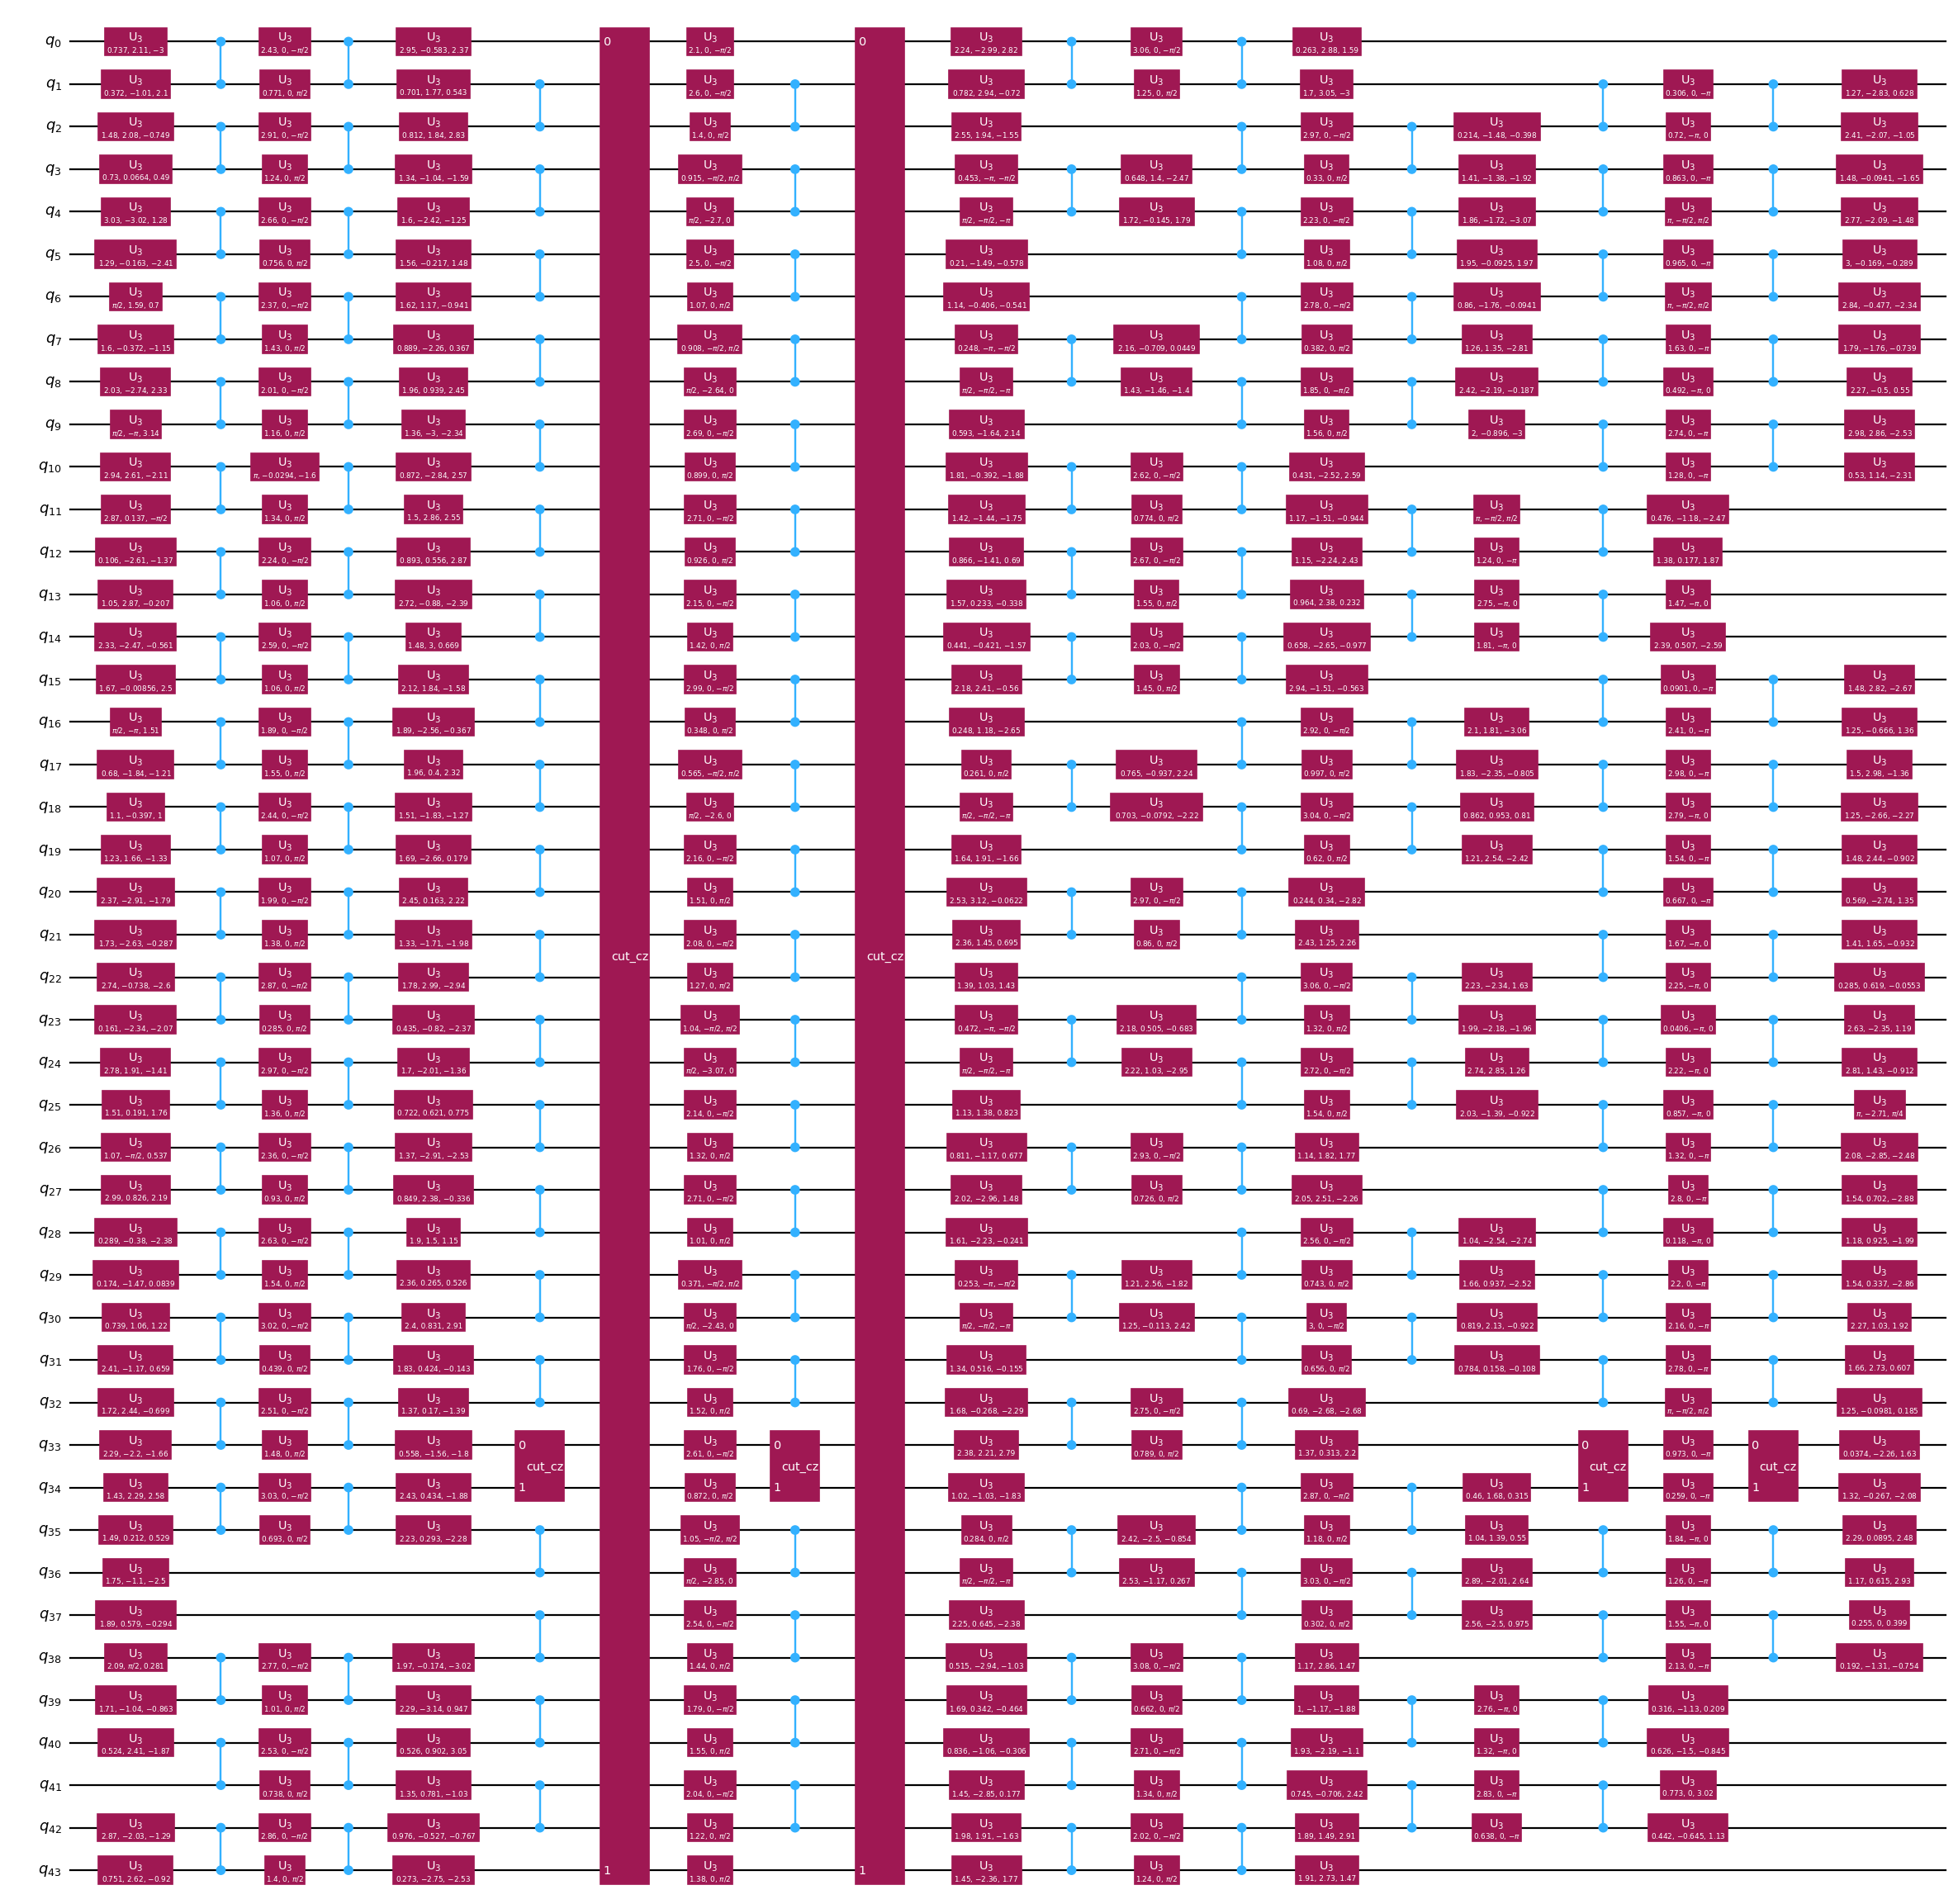

In [15]:
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

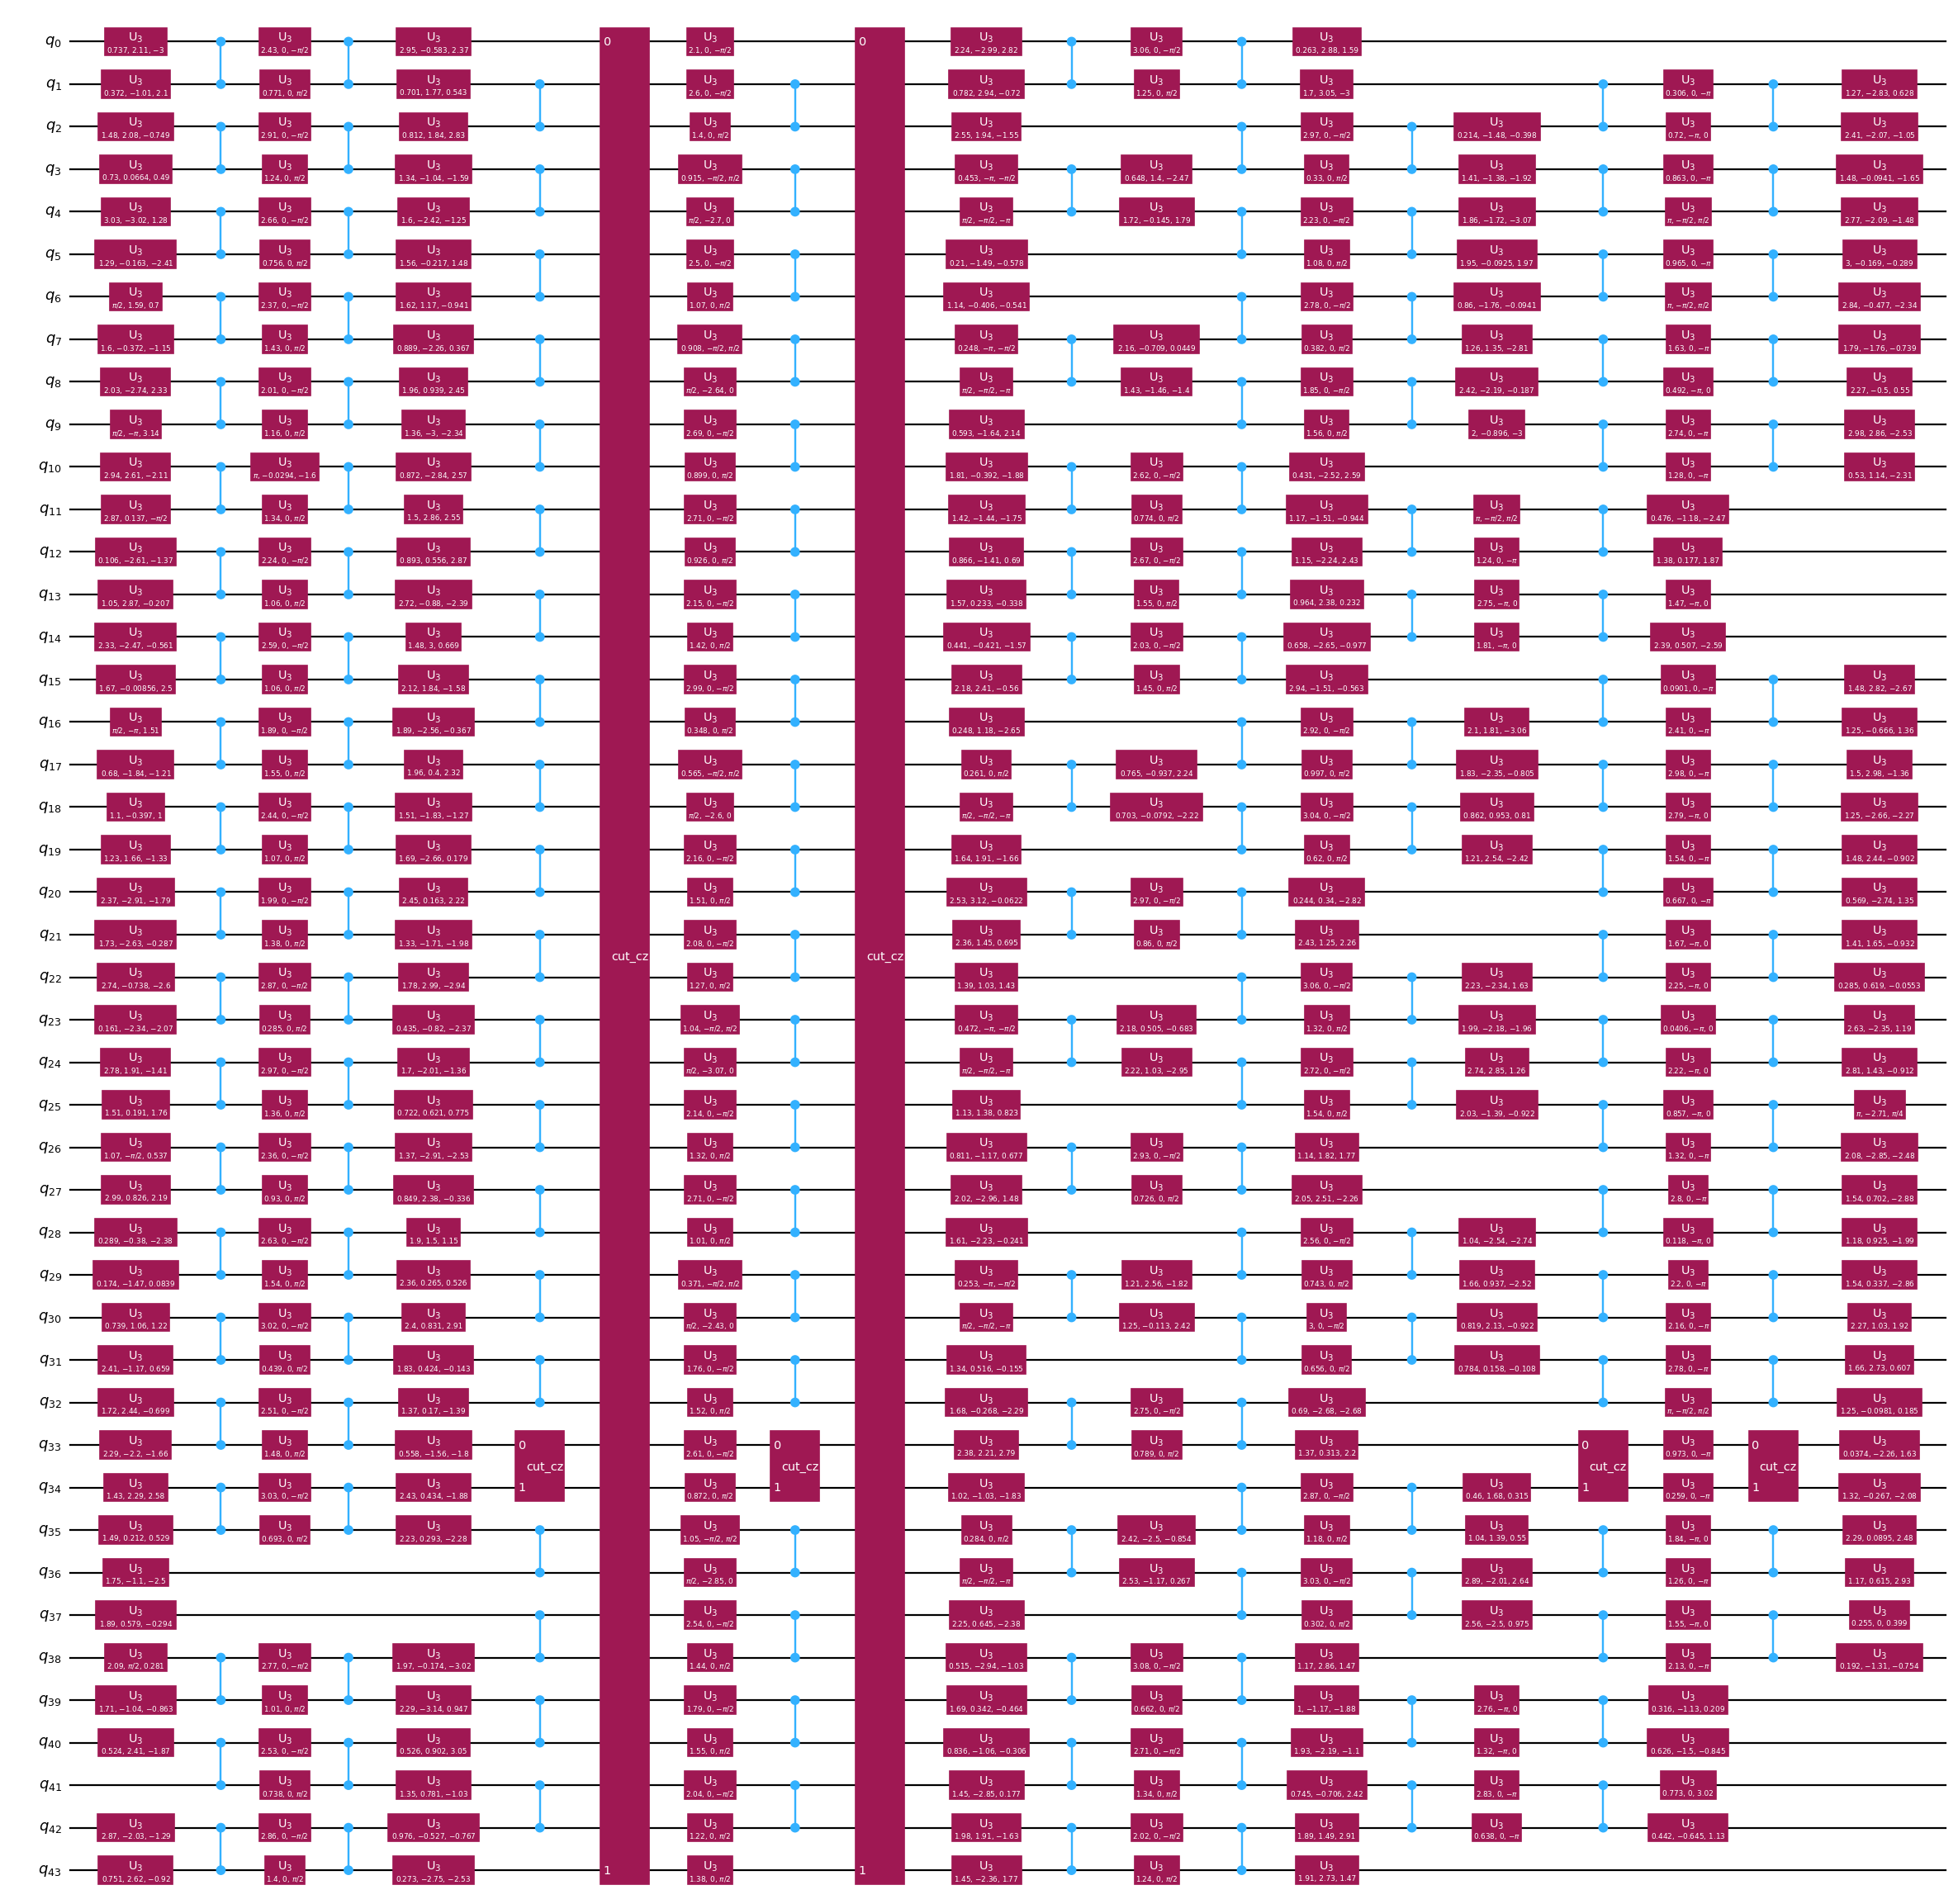

In [24]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, qc, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [25]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables = observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

Sampling overhead: 531441.0


In [26]:
print(subobservables)

{0: PauliList(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIII',
           'IIII

In [28]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

1976 total subexperiments to run on backend.


In [31]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [29]:
from qiskit_ibm_runtime import SamplerV2, Batch

In [32]:
# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

c:\Users\danie\anaconda3\envs\q_env\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:857: UserWarning: Your current pending jobs are estimated to consume 756.8557638399182 quantum seconds, but you only have 587 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)
c:\Users\danie\anaconda3\envs\q_env\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:857: UserWarning: Your current pending jobs are estimated to consume 1513.7115276798363 quantum seconds, but you only have 587 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [33]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

KeyboardInterrupt: 

# Parte dos de trabajo

In [30]:
pp = partition_problem(circuit=qc, partition_labels="AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBBBBBBBBB")

In [31]:
subcircuits = pp.subcircuits

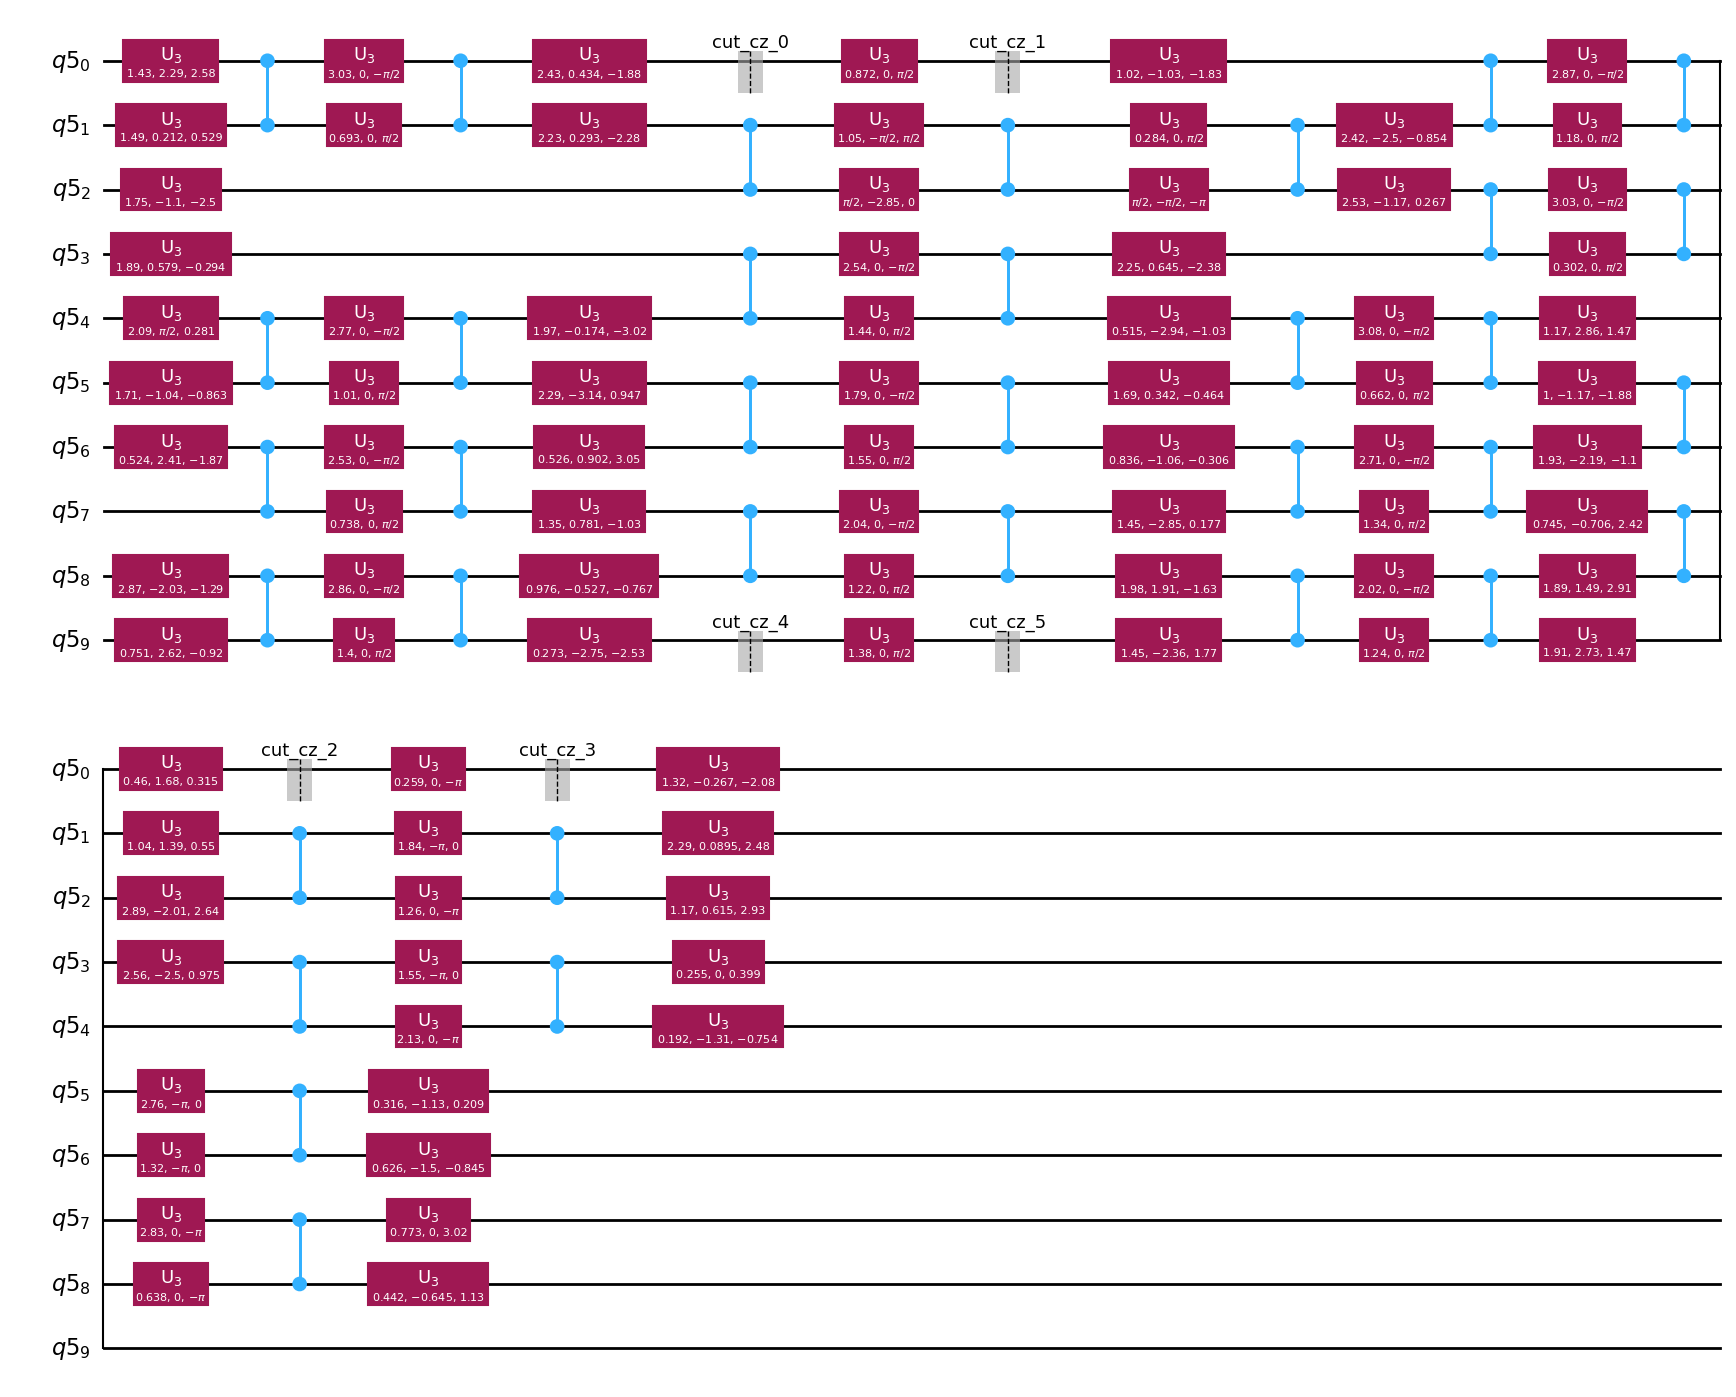

In [32]:
subcircuits["A"].draw('mpl', filename='P3subcircuit_A.png')
subcircuits["B"].draw('mpl', filename='P3subcircuit_B.png')

In [51]:
c1 = subcircuits[0].decompose()
c2 = subcircuits[1].decompose()

In [53]:
from qiskit import transpile

In [60]:
c1 = c1.decompose(reps=22)


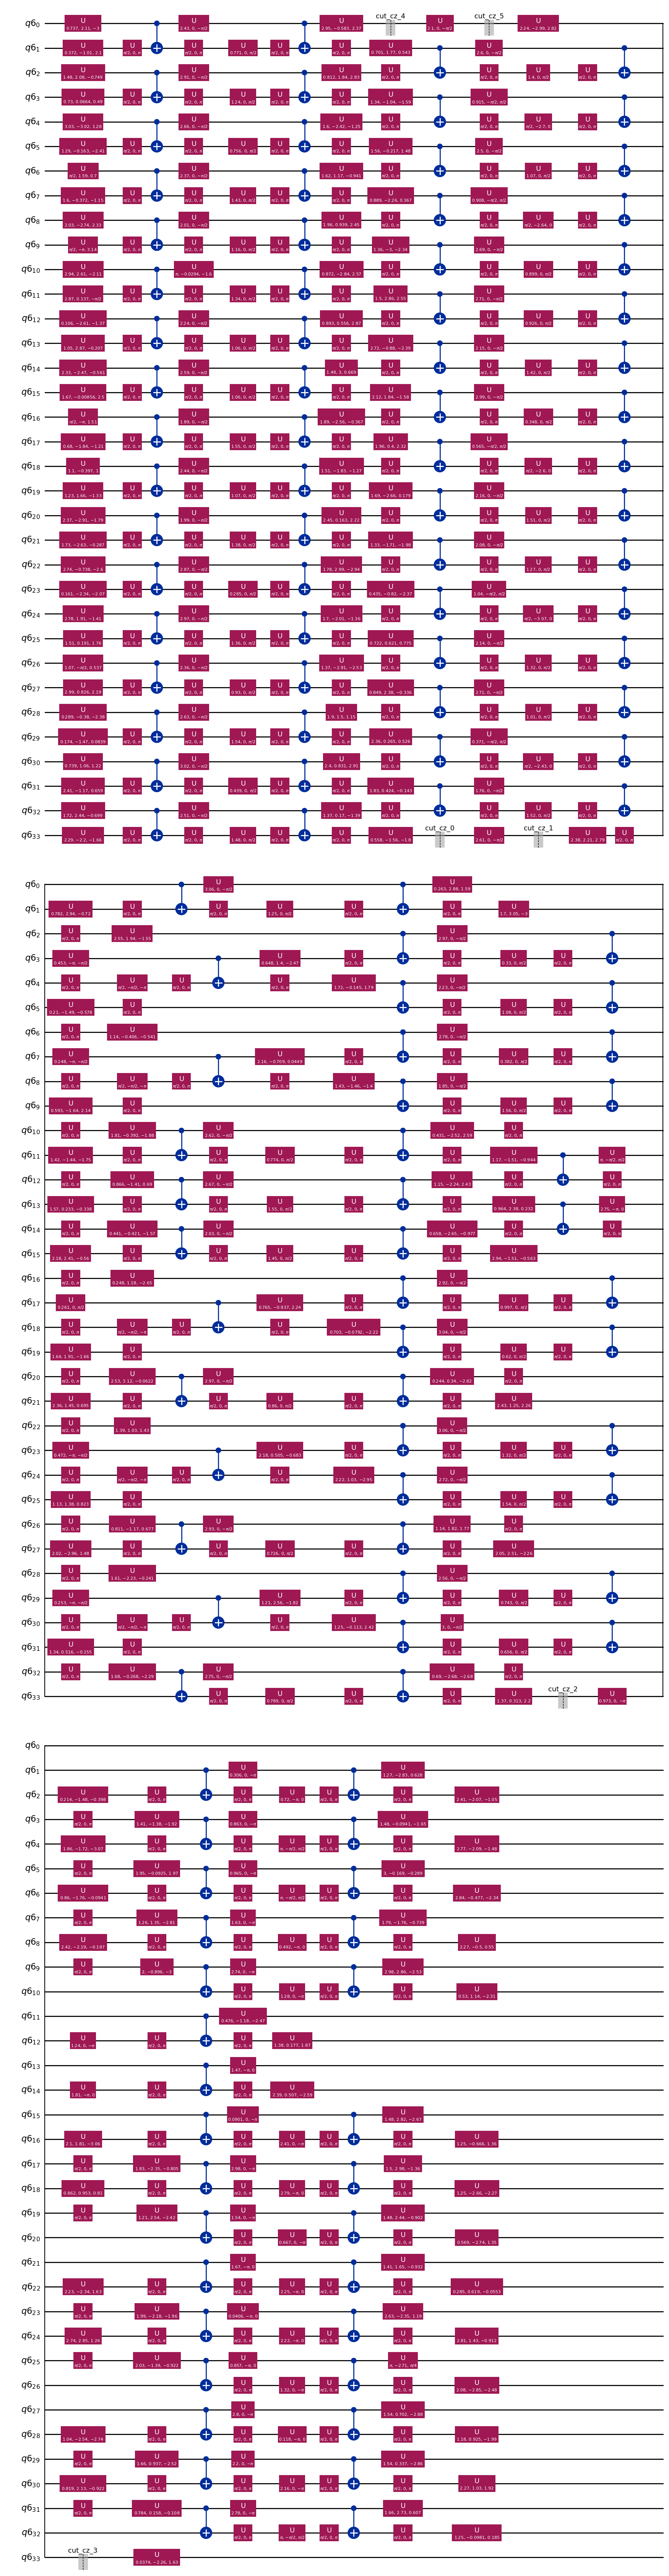

In [62]:
c1.draw('mpl', filename='P3subcircuit_A_decomposed.png')

In [15]:
bq = bluequbit.init(TOKEN) # <-- BlueQubit Magic

[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


In [17]:
from qiskit_addon_cutting import generate_cutting_experiments
import numpy as np

In [33]:
bases = pp.bases

In [35]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 531441.0


In [19]:
from qiskit_ibm_runtime import Batch

In [15]:
result = job.get_counts()

In [16]:
peak_bitstring = max(results, key=results.get)
print("Peak bitstring:", peak_bitstring)

Peak bitstring: 1100101101100011011000011100


### Corriendo en mps

In [36]:
job = bq.run(qc, job_name="P3 Counts Peak Bit String", shots=1024, device="mps.cpu") # <-- BlueQubit Magic
results = job.get_counts() # <-- BlueQubit Magic
print("Counts:", results)

[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tm4I4bO5jJCPYjVS, name: P3 Counts Peak Bit String, device: mps.cpu, run status: RUNNING, created on: 2025-04-12 18:41:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 44
Counts: {'00001100111100100000011111001101101100011010': 1, '00001101010000010000011100101100010100011010': 1, '00001101010101010000010111001101000100011010': 1, '00001101010101010000011111001101000100011001': 1, '00001101010101010000011111001101101100011010': 1, '00001101010101010001000111001101000100011010': 1, '00001101010101010010001111001101100100011001': 1, '00001101010101100000011111001101000010011001': 1, '00001101010101100000011111001101000101101101': 1, '00001101101101010010011100101101000100011001': 1, '00001101111101010000011111001101000100011001': 1, '00101001010100100000011111011111000100011001': 1, '00101101010101010000011111001101000100011001': 1, '00101101010101010000011111001101000100011010': 1, '001011010101010100000111110011011111000111

In [37]:
peak_bitstring = max(results, key=results.get)
print("Peak bitstring:", peak_bitstring)

Peak bitstring: 10001101010101010000011111001101000100011010


In [38]:
inverse_bitstring = min(results, key=results.get)
print("Inverse bitstring:", inverse_bitstring)

Inverse bitstring: 00001100111100100000011111001101101100011010
